# Data Preparing And Preprocessing

In [1]:
!pip install nltk
!pip install wordcloud
!pip install yellowbrick
!pip install kneed
!pip install gensim
!pip install transformers
!pip install pyLDAvis
!pip install tabulate
import pandas as pd
import random
import re
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tabulate import tabulate
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string, time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from yellowbrick.text import TSNEVisualizer

from sklearn.preprocessing import LabelEncoder, label_binarize

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, multilabel_confusion_matrix, classification_report

from sklearn.metrics import silhouette_score, cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

from kneed import KneeLocator

from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
import gensim
import gensim.downloader as api
import pickle

import plotly.express as px
import spacy
from gensim.models import KeyedVectors
from gensim.models import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import torch

import plotly.graph_objects as go
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# This variable uses in findall() function of a regular expression to get required samples.
sampleRegex = r"(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))"

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Initialize WordNetLemmatizer and PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
#porter_stemmer = PorterStemmer()

# This function takes two parameters (list of samples and any string). It drops this string from list.
def cleanedListFun(List, st):
    lst = [x for x in List if str(x) != st]
    return lst

# This function takes any path book and returns data partitions and its title.
def TextDataPartitioning(url=""):
    response = requests.get(url)
    txtBook = response.text
    raw = txtBook
    # Find all required samples in txtBook by using sampleRegex and return the result in list.
    lst = re.findall(sampleRegex, txtBook)
    # drop "NaN" and 'Unnamed' from List
    cleanedList = cleanedListFun(lst, 'NaN')
    cleanedList = cleanedListFun(cleanedList, 'Unnamed')

    stIndex = []
    lstPartitions = []
    random.seed(42)
    # divide List into 200 partitions, each partition contains 100 random samples.
    for i in range(0, 200):
        # randint () function puts random number in variable from particular range.
        l = random.randint(0, len(cleanedList) - 100)
        # This option cancels repeating the same partition.
        if l not in stIndex:
            stIndex.append(l)
            lstPartitions.append(cleanedList[l:l + 100])
        else:
            lstPartitions.append(cleanedList[l - 1:l + 99])

    # Remove stopwords and perform lemmatization on each partition
    processed_partitions = []
    for partition in lstPartitions:
        filtered_partition = [word for word in partition if word.lower() not in stop_words]
        lemmatized_partition = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in filtered_partition]
       # stemmed_partition = [porter_stemmer.stem(word) for word in lemmatized_partition]
        processed_partitions.append(lemmatized_partition)

    # create object dataframe from pandas library to put partitions
    df = pd.DataFrame()
    df["Paragraphs"] = processed_partitions

    return df,raw

In [3]:
import pandas as pd

books = {
    'The Adventures of Sherlock Holmes': {
        'author': 'Arthur Conan Doyle',
        'genre': 'Detective and mystery fiction',
        'url': 'https://www.gutenberg.org/files/1661/1661-0.txt'
    },
    'Queen Victoria': {
        'author': 'Lytton Strachey',
        'genre': 'Biography',
        'url': 'https://www.gutenberg.org/cache/epub/1265/pg1265.txt'
    },
    'Dracula': {
        'author': 'Bram Stoker',
        'genre': 'Horror',
        'url': 'https://www.gutenberg.org/cache/epub/345/pg345.txt'
    },
    'Pride and Prejudice': {
        'author': 'Jane Austen',
        'genre': 'Romance',
        'url': 'https://www.gutenberg.org/cache/epub/1342/pg1342.txt'
    },
    'The Great Gatsby': {
        'author': 'F. Scott Fitzgerald',
        'genre': 'Classic',
        'url': 'https://www.gutenberg.org/files/64317/64317-0.txt'
    }
}

FullData = pd.DataFrame(columns=['Author'])
df_for_sa = pd.DataFrame(columns=['Author', 'Text'])

for book, details in books.items():
    author = details['author']
    url = details['url']
    # Fetch and process the text data from the URL using TextDataPartitioning function
    text_data, raw = TextDataPartitioning(url)
    # Add book, author, nationality, and text data to the DataFrame
    text_data['Author'] = author
    book_dict = {'Author': [author], 'Text': [raw]}  # Wrap scalar values in a list

    # Append to the FullData DataFrame
    FullData = pd.concat([FullData, text_data], ignore_index=True)
    df_for_sa = pd.concat([df_for_sa, pd.DataFrame(book_dict)], ignore_index=True)

display(FullData)


Author                                         Paragraphs
0     Arthur Conan Doyle  [suddenly, hear, sound, step, within, room, sa...
1     Arthur Conan Doyle  [go, strange, wonderful, chain, work, lead, wo...
2     Arthur Conan Doyle  [wonderful, sympathy, freemasonry, among, hors...
3     Arthur Conan Doyle  [Look, Give, flick, horse, dash, away, endless...
4     Arthur Conan Doyle  [reasoner, able, utilise, facts, come, readily...
..                   ...                                                ...
995  F. Scott Fitzgerald  [continue, almost, Tom, turn, live, near, Sloa...
996  F. Scott Fitzgerald  [small, view, partial, view, console, proximit...
997  F. Scott Fitzgerald  [look, huge, incoherent, failure, house, white...
998  F. Scott Fitzgerald  [lunch, eat, four, worth, food, half, start, m...
999  F. Scott Fitzgerald  [friend, Jew, raise, large, head, regard, two,...

[1000 rows x 2 columns]

In [4]:
df = pd.DataFrame(FullData)
df.to_csv('partitions.csv', index=False)

In [5]:
# Convert 'Paragraphs' column to string type
df['Paragraphs'] = df['Paragraphs'].astype(str)

# Using the str.lower() method
df['Paragraphs'] = df['Paragraphs'].str.lower()

# Using the apply() method
df['Paragraphs'] = df['Paragraphs'].apply(lambda x: x.lower())
df

Author                                         Paragraphs
0     Arthur Conan Doyle  ['suddenly', 'hear', 'sound', 'step', 'within'...
1     Arthur Conan Doyle  ['go', 'strange', 'wonderful', 'chain', 'work'...
2     Arthur Conan Doyle  ['wonderful', 'sympathy', 'freemasonry', 'amon...
3     Arthur Conan Doyle  ['look', 'give', 'flick', 'horse', 'dash', 'aw...
4     Arthur Conan Doyle  ['reasoner', 'able', 'utilise', 'facts', 'come...
..                   ...                                                ...
995  F. Scott Fitzgerald  ['continue', 'almost', 'tom', 'turn', 'live', ...
996  F. Scott Fitzgerald  ['small', 'view', 'partial', 'view', 'console'...
997  F. Scott Fitzgerald  ['look', 'huge', 'incoherent', 'failure', 'hou...
998  F. Scott Fitzgerald  ['lunch', 'eat', 'four', 'worth', 'food', 'hal...
999  F. Scott Fitzgerald  ['friend', 'jew', 'raise', 'large', 'head', 'r...

[1000 rows x 2 columns]

In [6]:
exclude = string.punctuation
def remove_punct(text):
    for char in exclude:
        text = text.replace(char, '')
    return text
df['Paragraphs'].apply(remove_punct)

0      suddenly hear sound step within room saw shado...
1      go strange wonderful chain work lead would mak...
2      wonderful sympathy freemasonry among horsey on...
3      look give flick horse dash away endless succes...
4      reasoner able utilise facts come readily posse...
                             ...                        
995    continue almost tom turn live near sloane ente...
996    small view partial view console proximity eigh...
997    look huge incoherent failure house white step ...
998    lunch eat four worth food half start make rais...
999    friend jew raise large head regard two fine gr...
Name: Paragraphs, Length: 1000, dtype: object

In [7]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

df['Paragraphs'] = df['Paragraphs'].apply(remove_special_characters)
df

Author                                         Paragraphs
0     Arthur Conan Doyle  suddenly hear sound step within room saw shado...
1     Arthur Conan Doyle  go strange wonderful chain work lead would mak...
2     Arthur Conan Doyle  wonderful sympathy freemasonry among horsey on...
3     Arthur Conan Doyle  look give flick horse dash away endless succes...
4     Arthur Conan Doyle  reasoner able utilise facts come readily posse...
..                   ...                                                ...
995  F. Scott Fitzgerald  continue almost tom turn live near sloane ente...
996  F. Scott Fitzgerald  small view partial view console proximity eigh...
997  F. Scott Fitzgerald  look huge incoherent failure house white step ...
998  F. Scott Fitzgerald  lunch eat four worth food half start make rais...
999  F. Scott Fitzgerald  friend jew raise large head regard two fine gr...

[1000 rows x 2 columns]

# Feature Engineering

### Sentiment Analysis

In [8]:
def present_scores_as_table(list1, list2, list3):
    # Assuming all lists have the same length
    if len(list1) != len(list2) or len(list1) != len(list3):
        raise ValueError("All lists must have the same length.")

    # Combine the three lists into a list of triples
    triples = list(zip(list1, list2, list3))

    # Create a table with headers and the triples as rows
    table = tabulate(triples, headers=['Name', 'Score', 'Overall_Emotion'], tablefmt='rounded_outline')

    # Print the table
    print(table)

In [9]:
def SentimentAnalysis(df):

    scores = []
    overall_emotions = []

    for number in range(len(df)):

        # Instantiate the sentiment analyzer
        sia = SentimentIntensityAnalyzer()

        # Analyze the sentiment for each sentence in the book
        sentences = nltk.sent_tokenize(df['Text'][number])
        sentiment_scores = [sia.polarity_scores(sentence) for sentence in sentences]

        # Calculate the overall sentiment score for the book
        compound_scores = [score['compound'] for score in sentiment_scores]
        overall_sentiment = sum(compound_scores) / len(compound_scores)

        # Calculate the overall sentiment score for the book
        overall_sentiment = sum(compound_scores) / len(compound_scores)

        # Determine the overall emotion
        if overall_sentiment >= 0.05:
            overall_emotions.append('Positive')
        elif overall_sentiment <= -0.05:
            overall_emotions.append('Negative')
        else:
            overall_emotions.append('Neutral')

        scores.append(f"{overall_sentiment:.2f}")

    present_scores_as_table(df['Author'],scores,overall_emotions)

In [10]:
#This is SentimentAnalysis
SentimentAnalysis(df_for_sa)

Name                   Score  Overall_Emotion
-------------------  -------  -----------------
Arthur Conan Doyle      0.05  Neutral
Lytton Strachey         0.1   Positive
Bram Stoker             0.05  Neutral
Jane Austen             0.19  Positive
F. Scott Fitzgerald     0.05  Positive


### Visualization


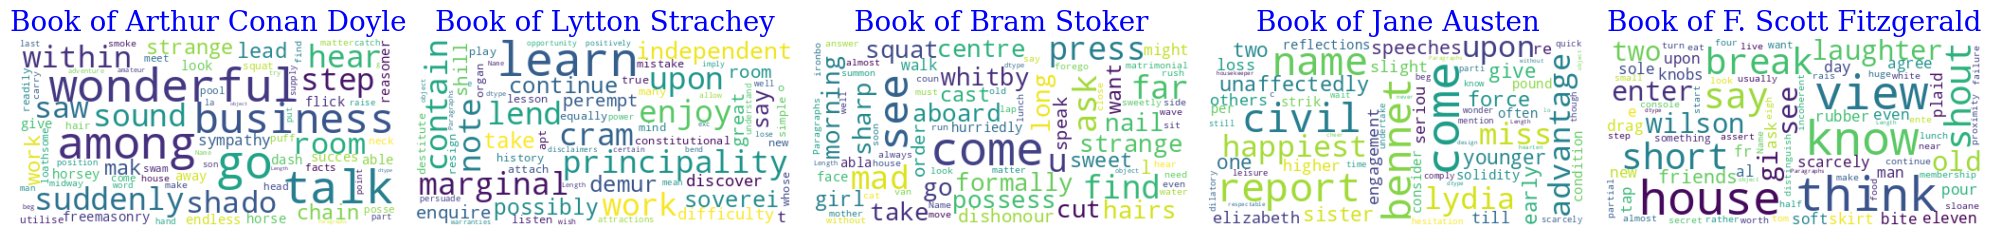

In [11]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")

# Generate a wordcloud
indx = 199

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 6))

for i, ax in enumerate(axes.flatten()):
    wc.generate(str(df[(indx - 200) + 1: indx]["Paragraphs"]))
    ax.imshow(wc, interpolation="bilinear")
    title = "Book of {}".format(str(df.loc[indx]["Author"]))
    font1 = {'family': 'serif', 'color': 'blue', 'size': 20}
    ax.set_title(title, fontdict=font1)
    ax.axis('off')
    indx += 200

plt.tight_layout()
plt.show()

<Axes: xlabel='Author', ylabel='count'>

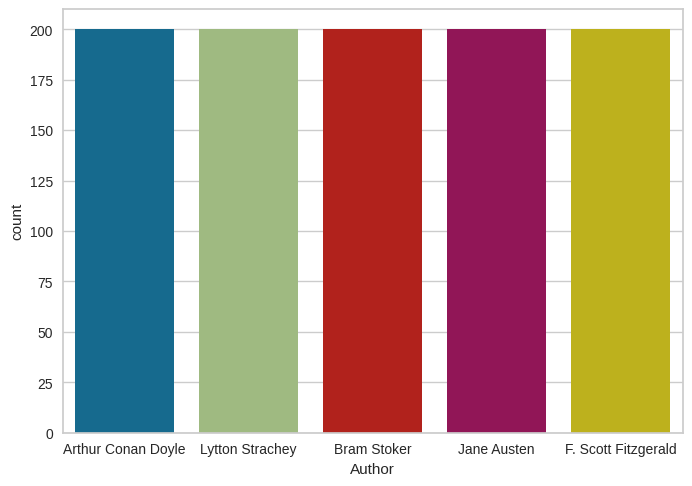

In [12]:
sns.countplot(x=df['Author'])

In [13]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


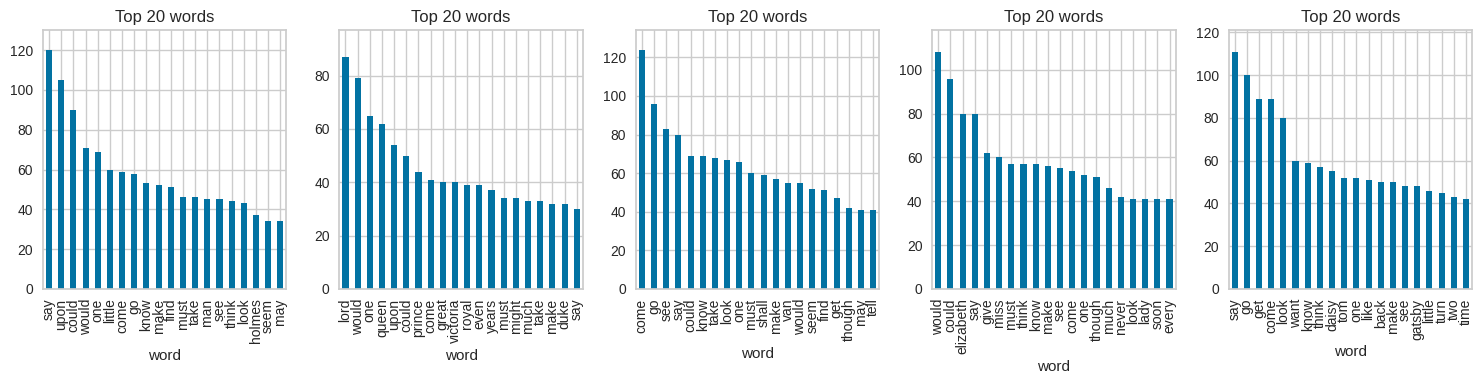

In [14]:
indx = 199

fig, axs = plt.subplots(1, 5, figsize=(15, 4))  # Create a figure with 1 row and 5 columns

for i in range(5):
    common_words = get_top_n_words(df[(indx - 200) + 1: indx]["Paragraphs"], 20)

    df1 = pd.DataFrame(common_words, columns=['word', 'count'])
    ax = axs[i]  # Select the appropriate subplot
    df1.groupby('word').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words', ax=ax)
    ax.set_ylim([0, df1['count'].max() + 10])  # Set y-axis limits to ensure consistent scaling
    indx += 200

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Tranfromation

In [15]:
def plot_TSNE(data,labels):
    # tsne = TSNE(n_components=2, random_state=42)
    tsne = TSNEVisualizer()
    tsne.fit(data,labels)
    plt.xlabel("TSNE x")
    plt.ylabel("TSNE y")
    tsne.show()

In [16]:
import plotly.express as px
from sklearn.decomposition import PCA

def plot_PCA(data, labels):
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)

    d=pd.DataFrame({'PCA1':pca_data[:,0],'PCA2':pca_data[:,1],'Target':labels})
    fig = px.scatter(data_frame =d, x='PCA1', y='PCA2', color='Target')
    fig.update_layout(title={'text':'PCA','x':0.5},height=500,width=700)
    fig.show()


In [17]:
import gensim.downloader as api
def get_vectors_pretrained(data_frame, model):
    embedding_vectors = []
    for partition in data_frame['Paragraphs']:
        sentence = []
        for word in partition.split(' '):
            try:
                sentence.append(model[word])
            except:
                pass
        sentence = np.array(sentence)
        sentence = sentence.mean(axis=0)
        embedding_vectors.append(sentence)
    embedding_vectors = np.array(embedding_vectors)
    return embedding_vectors

##### BOW

In [18]:
#BOW
def BOW():
    cv = CountVectorizer()
    cv_matrix = cv.fit_transform(df['Paragraphs'])
    cv_matrix = cv_matrix.toarray()
    # get all unique words in the corpus
    vocab = cv.get_feature_names_out()
    # show document feature vectors
    data = pd.DataFrame(cv_matrix, columns=vocab)
    return data

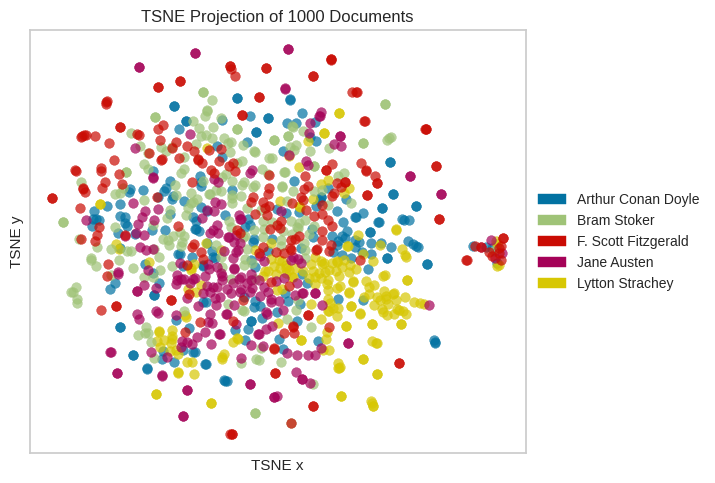

In [19]:
plot_TSNE(BOW(),df['Author'])

In [20]:
plot_PCA(BOW(),df['Author'])

##### TF-IDF

In [21]:
#TF-IDF
def TFIDF():
    tv = TfidfVectorizer()
    tv_matrix = tv.fit_transform(df['Paragraphs'])
    tv_matrix = tv_matrix.toarray()
    vocab = tv.get_feature_names_out()
    data = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
    return data

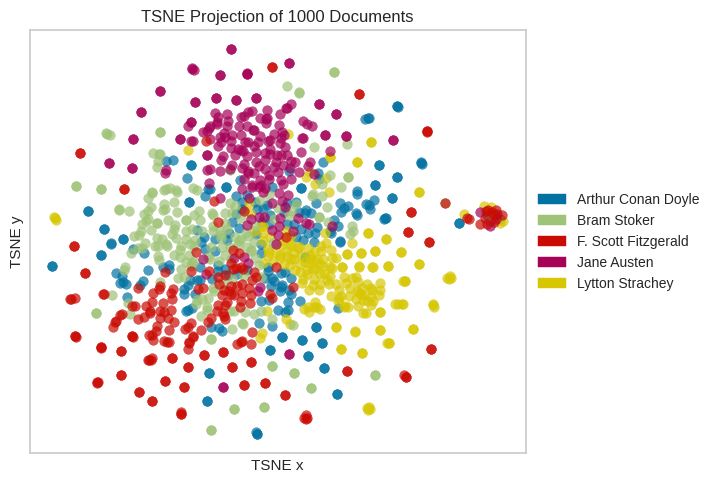

In [22]:
plot_TSNE(TFIDF(),df['Author'])

In [23]:
plot_PCA(TFIDF(),df['Author'])

##### Word2Vec

In [24]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd

def word2vec_transform():
    # Train the Word2Vec model
    sentences = [paragraph.split() for paragraph in df['Paragraphs']]
    model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, epochs = 100,seed=42)

    # Transform each paragraph using Word2Vec
    transformed_data = []
    for paragraph in sentences:
        paragraph_vector = np.mean([model.wv[word] for word in paragraph], axis=0)
        transformed_data.append(paragraph_vector)

    # Create a DataFrame from the transformed data
    vocab = [f"feature_{i+1}" for i in range(model.vector_size)]
    data = pd.DataFrame(transformed_data, columns=vocab)

    return data


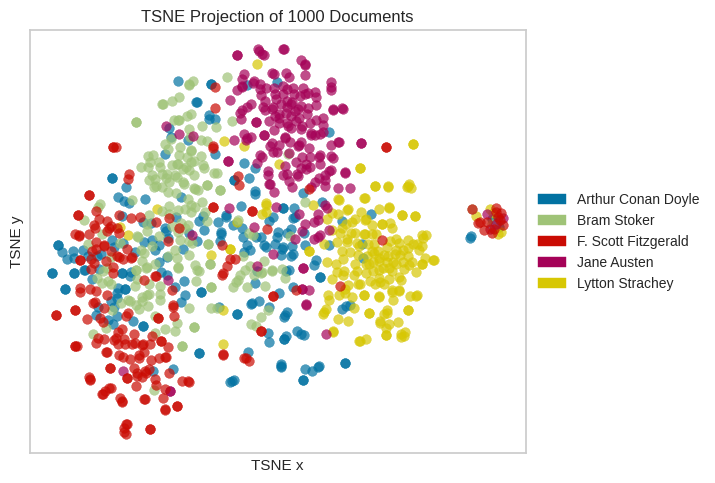

In [25]:
plot_TSNE(word2vec_transform(),df['Author'])

In [26]:
plot_PCA(word2vec_transform(),df['Author'])

##### Doc2Vec

In [27]:
def doc2vec_transform():
    tokenized_paragraphs = [word_tokenize(paragraph) for paragraph in df['Paragraphs']]

    # Train Doc2Vec model
    documents = [TaggedDocument(words=paragraph, tags=[i]) for i, paragraph in enumerate(tokenized_paragraphs)]
    model = Doc2Vec(documents, vector_size=50, window=5, min_count=1, workers=4, epochs=100, seed=42)

    # Get the document vectors
    doc_vectors = np.array([model.docvecs[i] for i in range(len(tokenized_paragraphs))])
    return doc_vectors

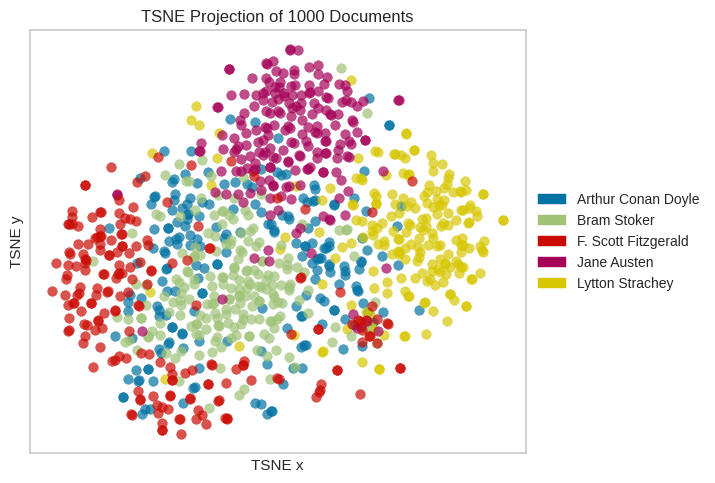

In [28]:
plot_TSNE(doc2vec_transform(),df['Author'])

In [29]:
plot_PCA(doc2vec_transform(),df['Author'])

##### FastText

In [30]:
def fasttext_transform():
    # Tokenize the paragraphs
    tokenized_paragraphs = [word_tokenize(paragraph) for paragraph in df['Paragraphs']]

    # Train FastText model
    model = FastText(sentences=tokenized_paragraphs, vector_size=50, window=5, min_count=1, workers=4, epochs = 100,seed=42)

    # Get the document vectors
    fasttext = np.array([np.mean([model.wv[word] for word in paragraph if word in model.wv], axis=0) for paragraph in tokenized_paragraphs])

    return fasttext

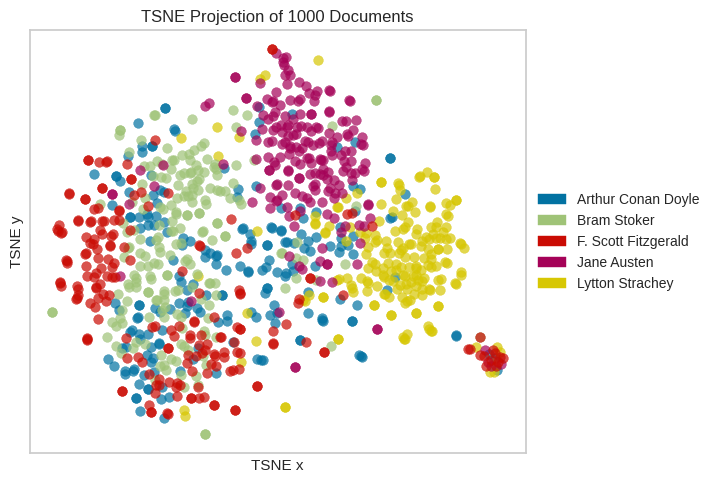

In [31]:
plot_TSNE(fasttext_transform(),df['Author'])

In [32]:
plot_PCA(fasttext_transform(),df['Author'])

##### Bert

In [33]:
#Bert Vectorizer
def Bert():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    word_vectors = []

    for text in df['Paragraphs']:
        # Tokenize text
        tokens = tokenizer.tokenize(text)
        # Convert tokens to token IDs
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        # Add special tokens
        token_ids = [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id]
        # Convert token IDs to PyTorch tensor
        token_tensor = torch.tensor([token_ids])
        # Obtain word vector
        with torch.no_grad():
            outputs = model(token_tensor)
            word_vector = outputs.last_hidden_state.squeeze(0).mean(dim=0)
        word_vectors.append(word_vector)

    word_vectors = torch.stack(word_vectors)
    return word_vectors

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


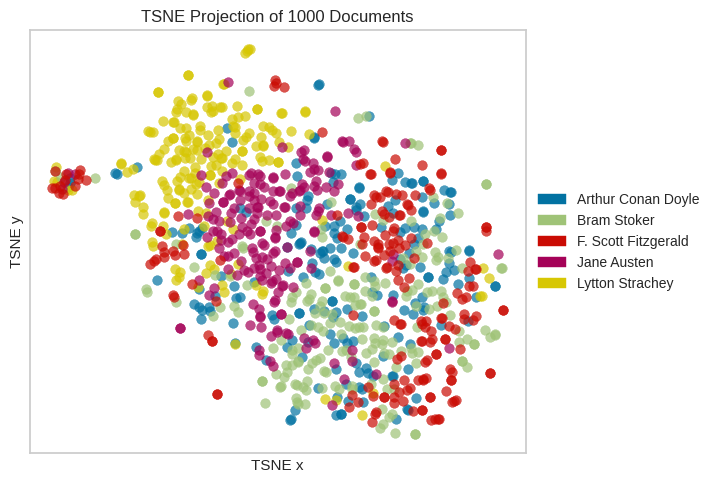

In [34]:
plot_TSNE(Bert(),df['Author'])

In [35]:
plot_PCA(Bert(),df['Author'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##### LDA

In [36]:
def lda_transform( num_topics=100):
    # Preprocess the documents
    processed_docs = [simple_preprocess(doc) for doc in df['Paragraphs']]

    # Create the dictionary
    dictionary = Dictionary(processed_docs)

    # Create the corpus
    corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    # Apply TF-IDF transformation
    tfidf = TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    # Train the LDA model
    lda = LdaModel(corpus_tfidf, num_topics=num_topics)

    # Transform the documents with LDA
    doc_lda = lda[corpus_tfidf]

    return doc_lda


In [37]:
paragraphs = df["Paragraphs"].to_list()
docs = []

for sen in paragraphs:
    docs.append(list(sen.split()))
print(len(docs))

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.8)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
print(len(corpus[2]))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

1000
23
Number of unique tokens: 369
Number of documents: 1000


In [38]:
# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
#print(len(dictionary))
model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -2.2260.


In [39]:
from gensim.models.coherencemodel import CoherenceModel
## Evaluating coherence of gensim LDA model
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence_score = cm.get_coherence()
print(coherence_score)

-2.22601041431061


In [40]:
all_topics = model.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
lda_to_cluster = all_topics_csr.T.toarray()
lda_to_cluster.shape

(1000, 5)

In [41]:
coherence_model = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print('Coherence Score: %.4f' % coherence_score)

Coherence Score: 0.3074


In [42]:
plot_PCA(lda_to_cluster,df['Author'])

##### LSA

In [43]:
#LSA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

def svd_transform():
    # raw documents to tf-idf matrix:
    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)

    # SVD to reduce dimensionality:
    svd_model = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=10)

    # pipeline of tf-idf + SVD, fit to and applied to documents:
    svd_transformer = Pipeline([('tfidf', vectorizer),
                                ('svd', svd_model)])
    svd_matrix = svd_transformer.fit_transform(df['Paragraphs'])

    return svd_matrix

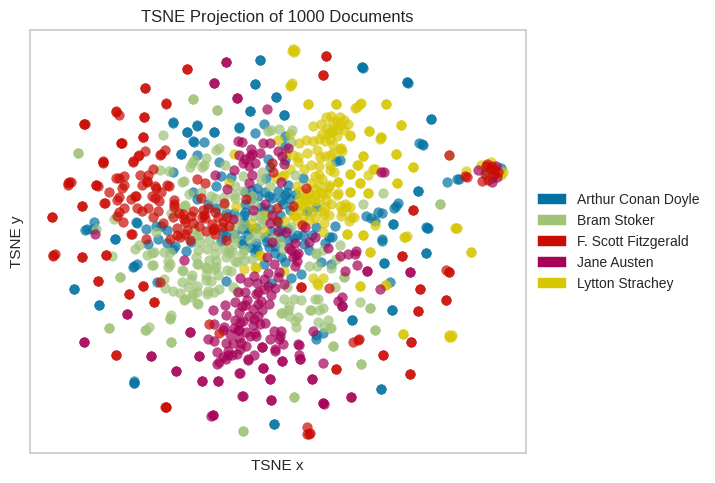

In [44]:
plot_TSNE(svd_transform(),df['Author'])

In [45]:
plot_PCA(svd_transform(),df['Author'])

# Modeling

In [46]:
BOW_Data = BOW()
TFIDF_Data = TFIDF()
Word2Vec_Data = word2vec_transform()
Doc2Vec_Data = doc2vec_transform()
FastText_Data = fasttext_transform()
BERT_Data = Bert()
LDA_Data = lda_to_cluster
LSA_Data = svd_transform()



text_embedding={
    'BOW': BOW_Data,
    'TF_IDF': TFIDF_Data,
    'Word2Vec': Word2Vec_Data,
    'Doc2Vec': Doc2Vec_Data,
    'FastText': FastText_Data,
    'BERT': BERT_Data,
    'LDA': lda_to_cluster,
    'LSA': LSA_Data
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
def encode_label():
  # Assuming you have a DataFrame 'df' with a target column named 'Author'
  y = df['Author']
  # Create an instance of the LabelEncoder
  label_encoder = LabelEncoder()
  # Fit and transform the target variable
  y_encoded = label_encoder.fit_transform(y)
  return y_encoded

In [48]:
def reduce_data(data, random_seed=None):
    pca = PCA(n_components=2, random_state=42)
    pca.fit(data)
    reduced_data = pca.transform(data)

    return reduced_data

In [49]:
def remap_labels(true_labels, predicted_labels):
    # Get unique true labels and predicted labels
    unique_true_labels = np.unique(true_labels)
    unique_predicted_labels = np.unique(predicted_labels)

    # Initialize array for remapped labels
    remapped_labels = np.zeros_like(predicted_labels)

    # Iterate over each predicted label cluster
    for cluster_label in unique_predicted_labels:
        # Get indices of samples belonging to the current cluster
        cluster_indices = np.where(predicted_labels == cluster_label)[0]

        # Extract true labels within the current cluster
        true_labels_in_cluster = true_labels[cluster_indices]

        # Count occurrences of each true label within the cluster
        unique_true_labels_in_cluster, counts = np.unique(true_labels_in_cluster, return_counts=True)

        # Select the most common true label as the remapped label for the cluster
        most_common_true_label = unique_true_labels_in_cluster[np.argmax(counts)]

        # Assign the remapped labels to the corresponding indices in the remapped_labels array
        remapped_labels[cluster_indices] = most_common_true_label

    return remapped_labels

In [50]:

def apply_PCA(data):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    return principalDf


In [51]:
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, cohen_kappa_score

def calculate_kappa_score(model_name):
    vecs = list(text_embedding.keys())
    vec_kappa = dict()

    for vec in vecs:
        if model_name == "Agglomerative":
            clustering_model = AgglomerativeClustering(n_clusters=5)
        elif model_name == "GaussianMixture":
            clustering_model = GaussianMixture(n_components=5, random_state=42)
        elif model_name == "KMeans":
            clustering_model = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter=300, random_state = 42, algorithm = 'full')

        else:
            raise ValueError("Invalid model name!")

        cluster_labels = clustering_model.fit_predict(reduce_data(text_embedding[vec]))
        cluster_score = silhouette_score(reduce_data(text_embedding[vec]), cluster_labels, metric='euclidean')

        true_labels = encode_label()
        mapped_labels = remap_labels(true_labels, cluster_labels)
        kappa_score = cohen_kappa_score(mapped_labels, cluster_labels)
        vec_kappa[vec] = kappa_score

    fig = go.Figure()
    obj = go.Bar(x=list(vec_kappa.keys()), y=list(vec_kappa.values()))
    fig.add_trace(obj)
    fig.update_layout(title={'text': f"Kappa Score for Different Vectorizers - {model_name}", 'x': 0.5}, height=600, width=600)
    fig.show()


### K-Means

In [52]:
def kmeans(data, n):

    n +=1
    kmeans_kwargs = {
        "init": 'k-means++',
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
        "algorithm" : 'full'
    }
    # A list holds the SSE values for each k
    # A list holds the silhouette coefficients for each k
    sse = []
    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, n):
        k = KMeans(n_clusters=k, **kmeans_kwargs)
        k_labels = k.fit_predict(data)
        score = silhouette_score(data,k_labels, metric='euclidean')
        sse.append(k.inertia_)
        silhouette_coefficients.append(score)


    return sse, silhouette_coefficients




In [53]:
kmeans_elb_vec = dict()
kmeans_sil_vec = dict()
for k,v in text_embedding.items():
    kmeans_elb_results, kmeans_sil_results = kmeans(reduce_data(v), 10)
    kmeans_elb_vec[k] = kmeans_elb_results
    kmeans_sil_vec[k] = kmeans_sil_results

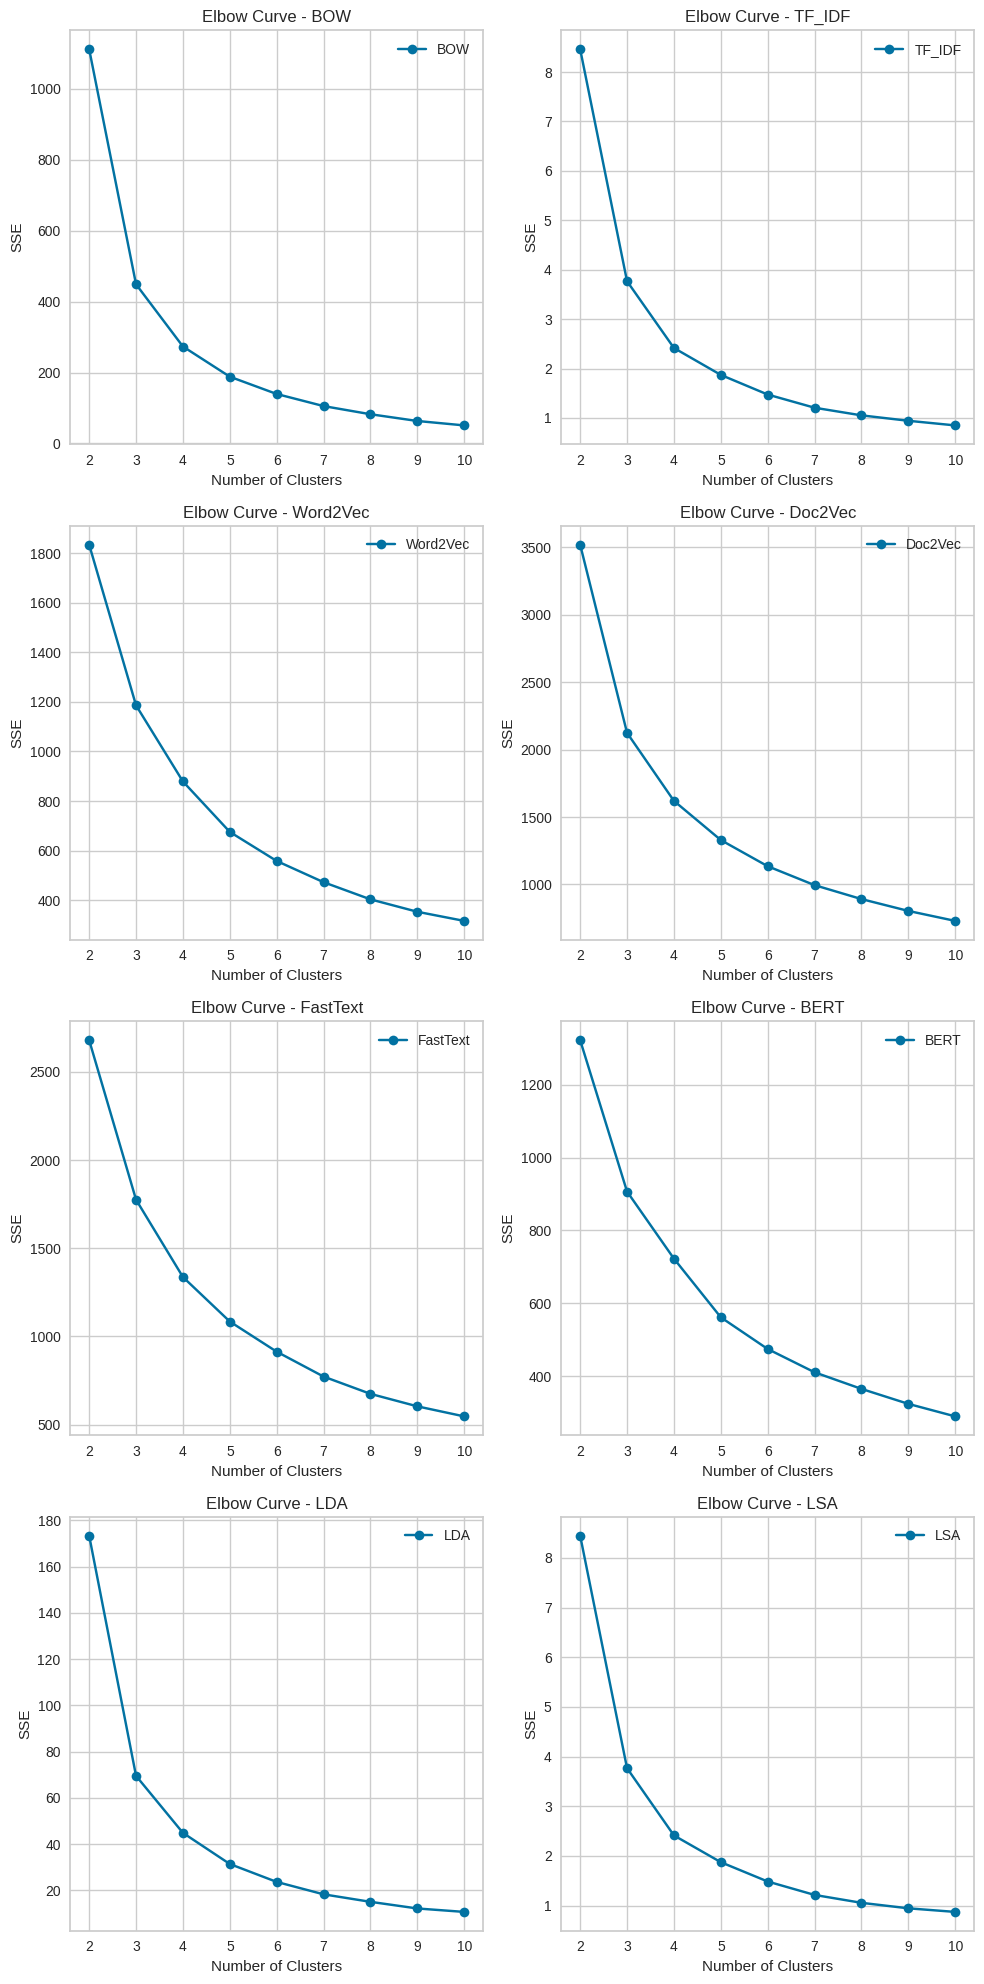

In [54]:
import matplotlib.pyplot as plt

# Assuming you have already executed the previous code and have the results in kmeans_elb_vec

# Calculate the number of text embeddings
num_embeddings = len(kmeans_elb_vec)

# Calculate the number of columns for subplots
num_cols = min(num_embeddings, 2)

# Calculate the number of rows for subplots
num_rows = (num_embeddings + num_cols - 1) // num_cols

# Create a figure and axes for subplots with the larger size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Ensure axes is always a 2D array
if num_rows == 1:
    axes = axes.reshape(1, -1)
elif num_cols == 1:
    axes = axes.reshape(-1, 1)

# Iterate over the text embeddings and their respective elbow results
for i, (k, v) in enumerate(kmeans_elb_vec.items()):
    ax = axes[i // num_cols, i % num_cols]  # Get the current axis

    ax.plot(range(2, len(v) + 2), v, marker='o', linestyle='-', label=k)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('SSE')
    ax.set_title(f'Elbow Curve - {k}')
    ax.legend()

# Hide unused subplots
if num_embeddings < num_rows * num_cols:
    for j in range(num_embeddings, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


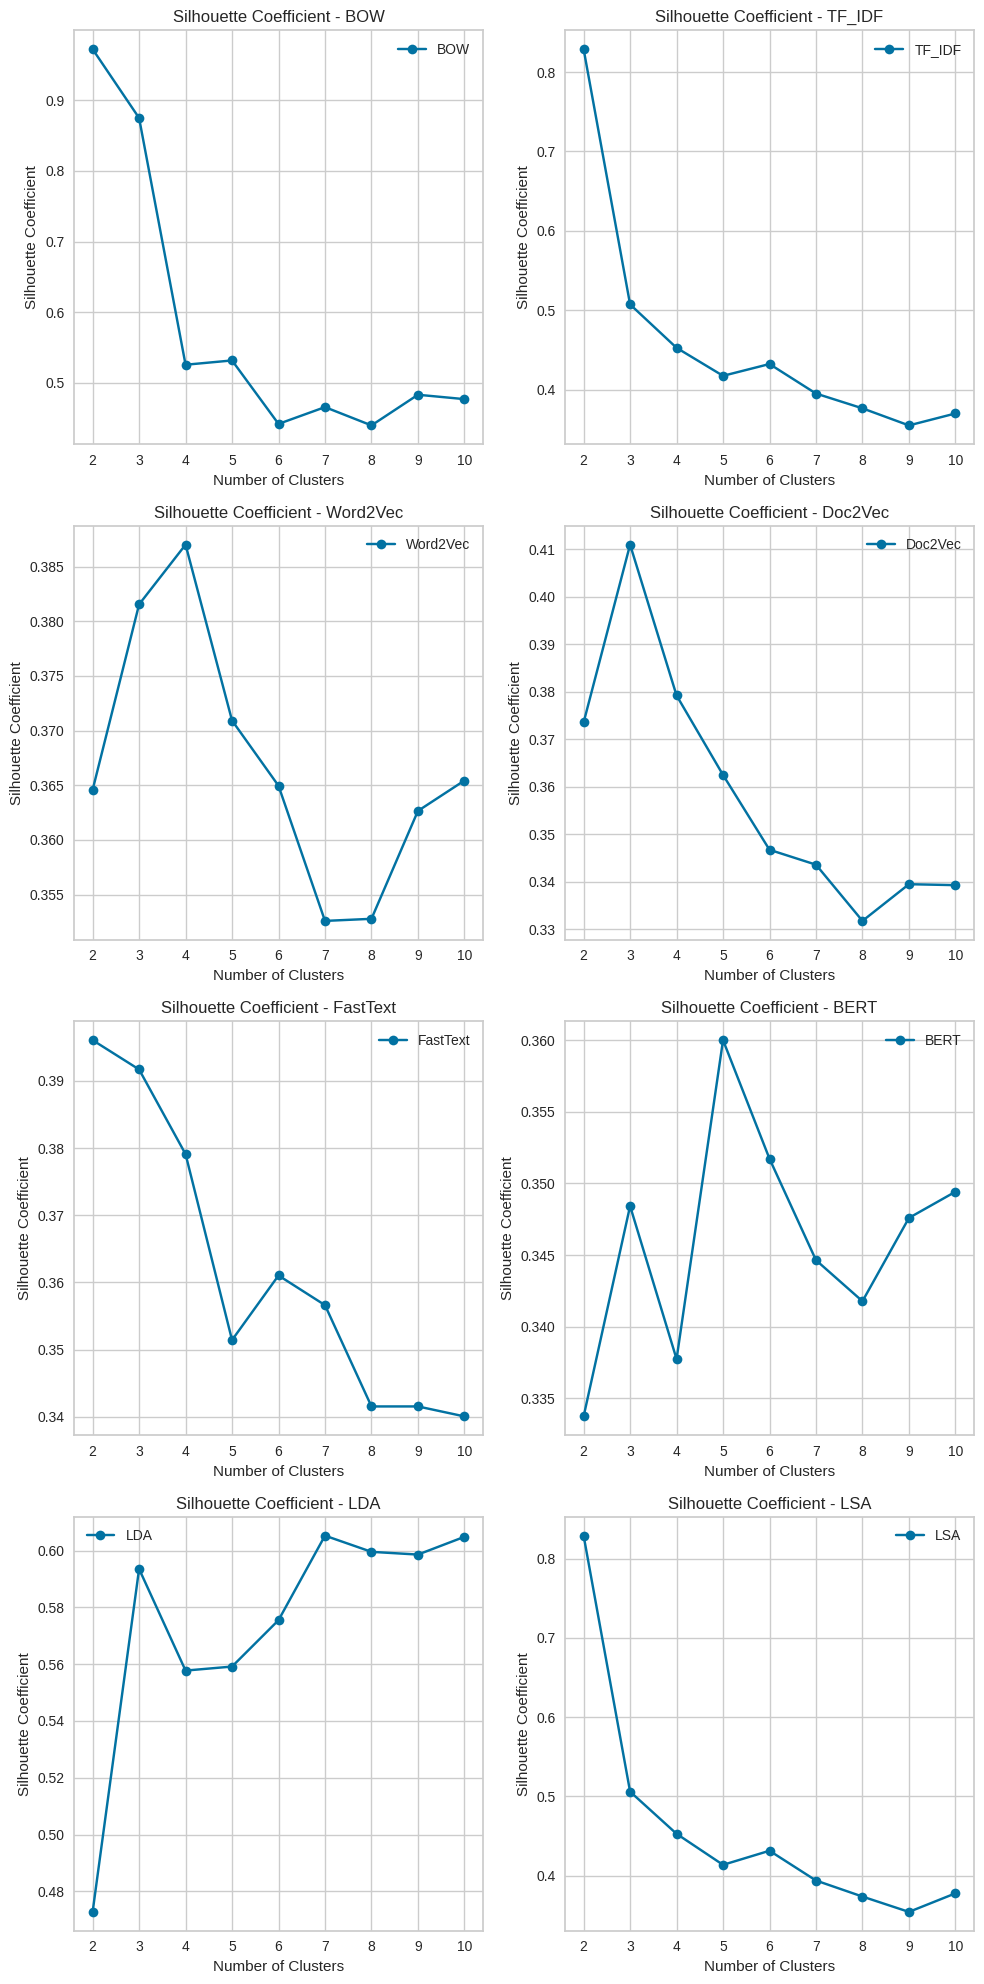

In [55]:
import matplotlib.pyplot as plt

# Assuming you have already executed the previous code and have the results in kmeans_sil_vec

# Calculate the number of text embeddings
num_embeddings = len(kmeans_sil_vec)

# Calculate the number of columns for subplots
num_cols = min(num_embeddings, 2)

# Calculate the number of rows for subplots
num_rows = (num_embeddings + num_cols - 1) // num_cols

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Ensure axes is always a 2D array
if num_rows == 1:
    axes = axes.reshape(1, -1)
elif num_cols == 1:
    axes = axes.reshape(-1, 1)

# Iterate over the text embeddings and their respective silhouette coefficients
for i, (k, v) in enumerate(kmeans_sil_vec.items()):
    ax = axes[i // num_cols, i % num_cols]  # Get the current axis

    ax.plot(range(2, len(v) + 2), v, marker='o', linestyle='-', label=k)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Coefficient')
    ax.set_title(f'Silhouette Coefficient - {k}')
    ax.legend()

# Hide unused subplots
if num_embeddings < num_rows * num_cols:
    for j in range(num_embeddings, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [56]:
from tabulate import tabulate

vecs = list(text_embedding.keys())
vec_kappa = dict()
results = []  # Store the results

for vec in vecs:
    kmeans_doc2vec = KMeans(n_clusters=5,
                            init='k-means++',
                            n_init=10,
                            max_iter=300,
                            random_state=42,
                            algorithm='full')
    kmeans_doc2vec.fit(reduce_data(text_embedding[vec]))
    y_predict = kmeans_doc2vec.predict(reduce_data(text_embedding[vec]))
    km_score = silhouette_score(reduce_data(text_embedding[vec]), y_predict, metric='euclidean')

    true_labels = encode_label()
    mapped_labels = remap_labels(true_labels, y_predict)
    kappa_score = cohen_kappa_score(mapped_labels, y_predict)

    # Append the results to the list
    results.append([vec, km_score, kappa_score])

# Tabulate the results
headers = ['Text Embedding', 'Silhouette Score', "Cohen's Kappa Score"]
table = tabulate(results, headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒══════════════════╤════════════════════╤═══════════════════════╕
│ Text Embedding   │   Silhouette Score │   Cohen's Kappa Score │
╞══════════════════╪════════════════════╪═══════════════════════╡
│ BOW              │           0.531864 │             0.228829  │
├──────────────────┼────────────────────┼───────────────────────┤
│ TF_IDF           │           0.417258 │             0.646811  │
├──────────────────┼────────────────────┼───────────────────────┤
│ Word2Vec         │           0.370918 │            -0.20851   │
├──────────────────┼────────────────────┼───────────────────────┤
│ Doc2Vec          │           0.362477 │            -0.0228452 │
├──────────────────┼────────────────────┼───────────────────────┤
│ FastText         │           0.351418 │            -0.0321092 │
├──────────────────┼────────────────────┼───────────────────────┤
│ BERT             │           0.360017 │             0.203621  │
├──────────────────┼────────────────────┼───────────────────────┤
│ LDA     

In [57]:
calculate_kappa_score("KMeans")


In [88]:
TF_IDF_kmeans=text_embedding['TF_IDF']

In [90]:
pca_df_kmeans = apply_PCA(TF_IDF_kmeans)
pca_df_final_kmeans = pd.concat([pca_df_kmeans, pd.Series(true_labels,name='target')],axis=1)
pca_df_final_kmeans

principal component 1  principal component 2  target
0                -0.051330               0.062793       0
1                 0.066522              -0.001794       0
2                -0.004012              -0.042777       0
3                 0.014104              -0.013005       0
4                 0.040302              -0.057904       0
..                     ...                    ...     ...
995              -0.084668               0.193287       2
996               0.004319               0.003114       2
997              -0.000528               0.013439       2
998               0.067072               0.103196       2
999              -0.046878               0.107751       2

[1000 rows x 3 columns]

In [91]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter=300, random_state = 42, algorithm = 'full')
kmeans.fit(pca_df_kmeans)
kmeans_labels = kmeans.predict(pca_df_kmeans)
kmeans_df_final = pd.concat([pca_df_kmeans, pd.Series(kmeans_labels,name='target')],axis=1)
centroids = kmeans.cluster_centers_
kmeans_df_final

principal component 1  principal component 2  target
0                -0.051330               0.062793       3
1                 0.066522              -0.001794       0
2                -0.004012              -0.042777       0
3                 0.014104              -0.013005       0
4                 0.040302              -0.057904       4
..                     ...                    ...     ...
995              -0.084668               0.193287       2
996               0.004319               0.003114       0
997              -0.000528               0.013439       0
998               0.067072               0.103196       3
999              -0.046878               0.107751       2

[1000 rows x 3 columns]

In [92]:
df_labels_kmeans = pd.DataFrame({'Labels': pca_df_final_kmeans['target'], 'Predicted Labels': list(kmeans_df_final['target'])})
predicted_labels = df_labels_kmeans['Predicted Labels'].values

# Remap the predicted labels based on the true labels
remapped_labels = remap_labels(df_labels_kmeans['Labels'].values, predicted_labels)

kmeans_df_final['target'] = remapped_labels


In [93]:
from plotly.subplots import make_subplots
fig1 = px.scatter(data_frame =pca_df_final_kmeans, x='principal component 1', y='principal component 2', color='target')
fig1.update_layout({'title':{'text': 'The Clusters with Actual Labels','x':0.5}},height=600,width=600)
fig1.show()
fig2 = px.scatter(data_frame =kmeans_df_final, x='principal component 1', y='principal component 2', color='target')
fig2.update_layout(annotations=[
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[0][0],
            y=centroids[0][1],
            text="X"),
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[1][0],
            y=centroids[1][1],
            text="X",
),
        dict(font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[2][0],
            y=centroids[2][1],
            text="X",
        ),
dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[3][0],
            y=centroids[3][1],
            text="X",
        ),dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[4][0],
            y=centroids[4][1],
            text="X",
        )],height=600,width=600)
fig2.update_layout({'title':{'text': 'The Clusters with K-means','x':0.5},},height=600,width=600)
fig2.show()

### EM

In [63]:
def gmm(data, n):

    n +=1

    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, n):
        gmm = GaussianMixture(k, random_state=42)
        gmm_labels = gmm.fit_predict(data)
        score = silhouette_score(data,gmm_labels, metric='euclidean')
        silhouette_coefficients.append(score)


    return silhouette_coefficients


In [64]:
gmm_sil_vec = dict()
for k,v in text_embedding.items():
    gmm_sil_results = gmm(reduce_data(v), 10)
    gmm_sil_vec[k] = gmm_sil_results

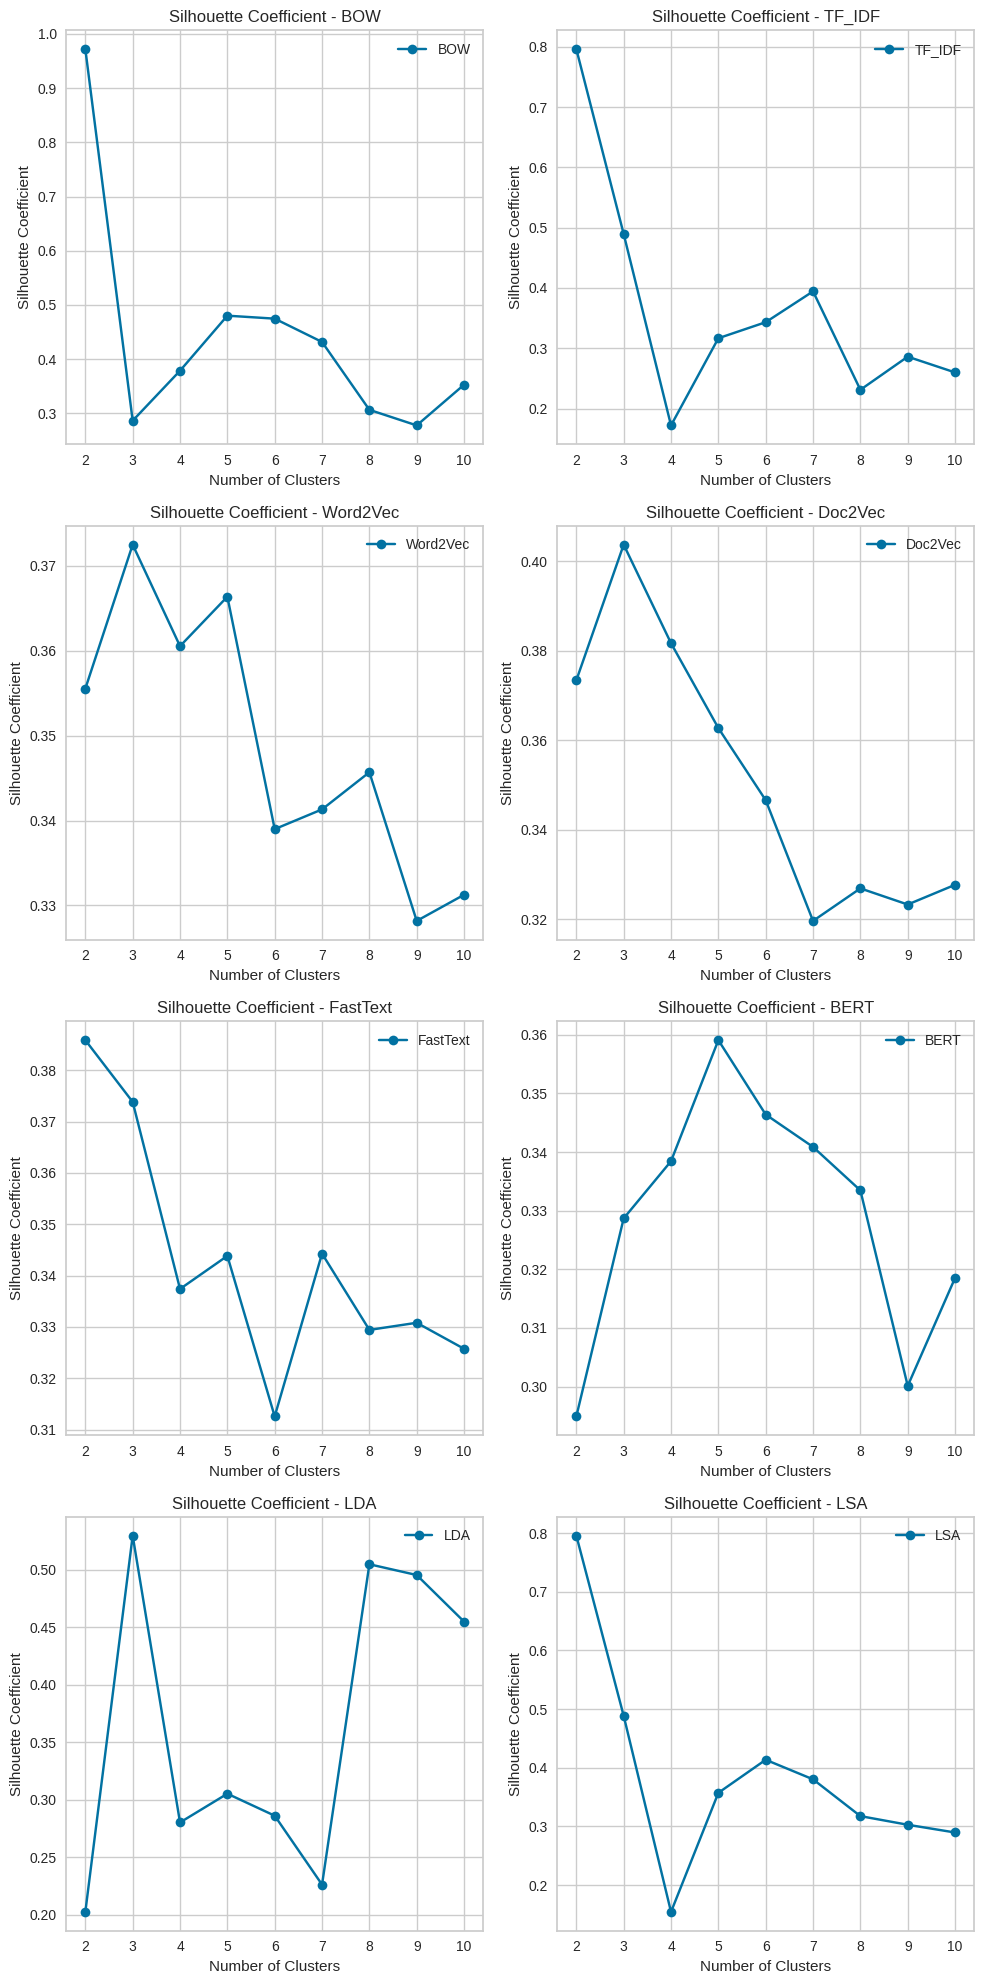

In [65]:
import matplotlib.pyplot as plt

# Assuming you have already executed the previous code and have the results in kmeans_sil_vec

# Calculate the number of text embeddings
num_embeddings = len(gmm_sil_vec)

# Calculate the number of columns for subplots
num_cols = min(num_embeddings, 2)

# Calculate the number of rows for subplots
num_rows = (num_embeddings + num_cols - 1) // num_cols

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Ensure axes is always a 2D array
if num_rows == 1:
    axes = axes.reshape(1, -1)
elif num_cols == 1:
    axes = axes.reshape(-1, 1)

# Iterate over the text embeddings and their respective silhouette coefficients
for i, (k, v) in enumerate(gmm_sil_vec.items()):
    ax = axes[i // num_cols, i % num_cols]  # Get the current axis

    ax.plot(range(2, len(v) + 2), v, marker='o', linestyle='-', label=k)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Coefficient')
    ax.set_title(f'Silhouette Coefficient - {k}')
    ax.legend()

# Hide unused subplots
if num_embeddings < num_rows * num_cols:
    for j in range(num_embeddings, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [66]:
vecs = list(text_embedding.keys())
vec_kappa = dict()
results = []  # Store the results

for vec in vecs:
    gmm = GaussianMixture(n_components=5, random_state=42)
    gmm.fit(reduce_data(text_embedding[vec]))
    gmm_labels = gmm.predict(reduce_data(text_embedding[vec]))
    gmm_score = silhouette_score(reduce_data(text_embedding[vec]), gmm_labels, metric='euclidean')

    true_labels = encode_label()
    mapped_labels = remap_labels(true_labels, gmm_labels)
    kappa_score = cohen_kappa_score(mapped_labels, gmm_labels)

    # Append the results to the list
    results.append([vec, gmm_score, kappa_score])
# Tabulate the results
headers = ['Text Embedding', 'Silhouette Score', "Cohen's Kappa Score"]
table = tabulate(results, headers, tablefmt='fancy_grid')

# Print the table
print(table)

╒══════════════════╤════════════════════╤═══════════════════════╕
│ Text Embedding   │   Silhouette Score │   Cohen's Kappa Score │
╞══════════════════╪════════════════════╪═══════════════════════╡
│ BOW              │           0.48009  │            -0.024244  │
├──────────────────┼────────────────────┼───────────────────────┤
│ TF_IDF           │           0.316662 │            -0.154098  │
├──────────────────┼────────────────────┼───────────────────────┤
│ Word2Vec         │           0.366364 │            -0.229119  │
├──────────────────┼────────────────────┼───────────────────────┤
│ Doc2Vec          │           0.362738 │            -0.0638505 │
├──────────────────┼────────────────────┼───────────────────────┤
│ FastText         │           0.343824 │             0.112739  │
├──────────────────┼────────────────────┼───────────────────────┤
│ BERT             │           0.359079 │            -0.309187  │
├──────────────────┼────────────────────┼───────────────────────┤
│ LDA     

In [67]:
calculate_kappa_score("GaussianMixture")

In [68]:
FastText_gmm=text_embedding['FastText']

In [69]:
pca_df_gmm = apply_PCA(FastText_gmm)
pca_df_final_gmm = pd.concat([pca_df_gmm, pd.Series(true_labels,name='target')],axis=1)
pca_df_final_gmm

principal component 1  principal component 2  target
0                -2.568871               1.164529       0
1                 1.439508               0.753416       0
2                -0.232676               1.831319       0
3                -0.874137               2.582007       0
4                 1.987433              -0.162411       0
..                     ...                    ...     ...
995              -2.085485              -0.335537       2
996               0.619617               1.715883       2
997              -0.863946               3.004836       2
998              -0.889707               1.400533       2
999              -1.940869               1.432761       2

[1000 rows x 3 columns]

In [70]:

gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(pca_df_gmm)
gmm_df_final = pd.concat([pca_df_gmm, pd.Series(gmm_labels, name='target')], axis=1)
centroids = gmm.means_
gmm_df_final


principal component 1  principal component 2  target
0                -2.568871               1.164529       1
1                 1.439508               0.753416       0
2                -0.232676               1.831319       4
3                -0.874137               2.582007       4
4                 1.987433              -0.162411       0
..                     ...                    ...     ...
995              -2.085485              -0.335537       1
996               0.619617               1.715883       4
997              -0.863946               3.004836       4
998              -0.889707               1.400533       4
999              -1.940869               1.432761       4

[1000 rows x 3 columns]

In [71]:
df_labels_gmm = pd.DataFrame({'Labels': pca_df_final_gmm['target'], 'Predicted Labels': list(gmm_df_final['target'])})
predicted_labels = df_labels_gmm['Predicted Labels'].values

# Remap the predicted labels based on the true labels
remapped_labels = remap_labels(df_labels_gmm['Labels'].values, predicted_labels)

gmm_df_final['target'] = remapped_labels


In [72]:
from plotly.subplots import make_subplots
fig1 = px.scatter(data_frame =pca_df_final_gmm, x='principal component 1', y='principal component 2', color='target')
fig1.update_layout({'title':{'text': 'The Clusters with Actual Labels','x':0.5}},height=600,width=600)
fig1.show()
fig2 = px.scatter(data_frame =gmm_df_final, x='principal component 1', y='principal component 2', color='target')
fig2.update_layout(annotations=[
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[0][0],
            y=centroids[0][1],
            text="X"),
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[1][0],
            y=centroids[1][1],
            text="X",
),
        dict(font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[2][0],
            y=centroids[2][1],
            text="X",
        ),
dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[3][0],
            y=centroids[3][1],
            text="X",
        ),dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[4][0],
            y=centroids[4][1],
            text="X",
        )],height=600,width=600)
fig2.update_layout({'title':{'text': 'The Clusters with EM','x':0.5},},height=600,width=600)
fig2.show()

### AgglomerativeClustering

In [73]:
def agg(data, n):

    n +=1

    silhouette_coefficients = []

    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, n):
        agg_clustering = AgglomerativeClustering(k)
        agg_labels = agg_clustering.fit_predict(data)
        agg_score = silhouette_score(data, agg_labels, metric='euclidean')
        silhouette_coefficients.append(agg_score)


    return silhouette_coefficients

In [74]:
agg_sil_vec = dict()
for k,v in text_embedding.items():
    agg_sil_results = agg(reduce_data(v), 10)
    agg_sil_vec[k] = agg_sil_results

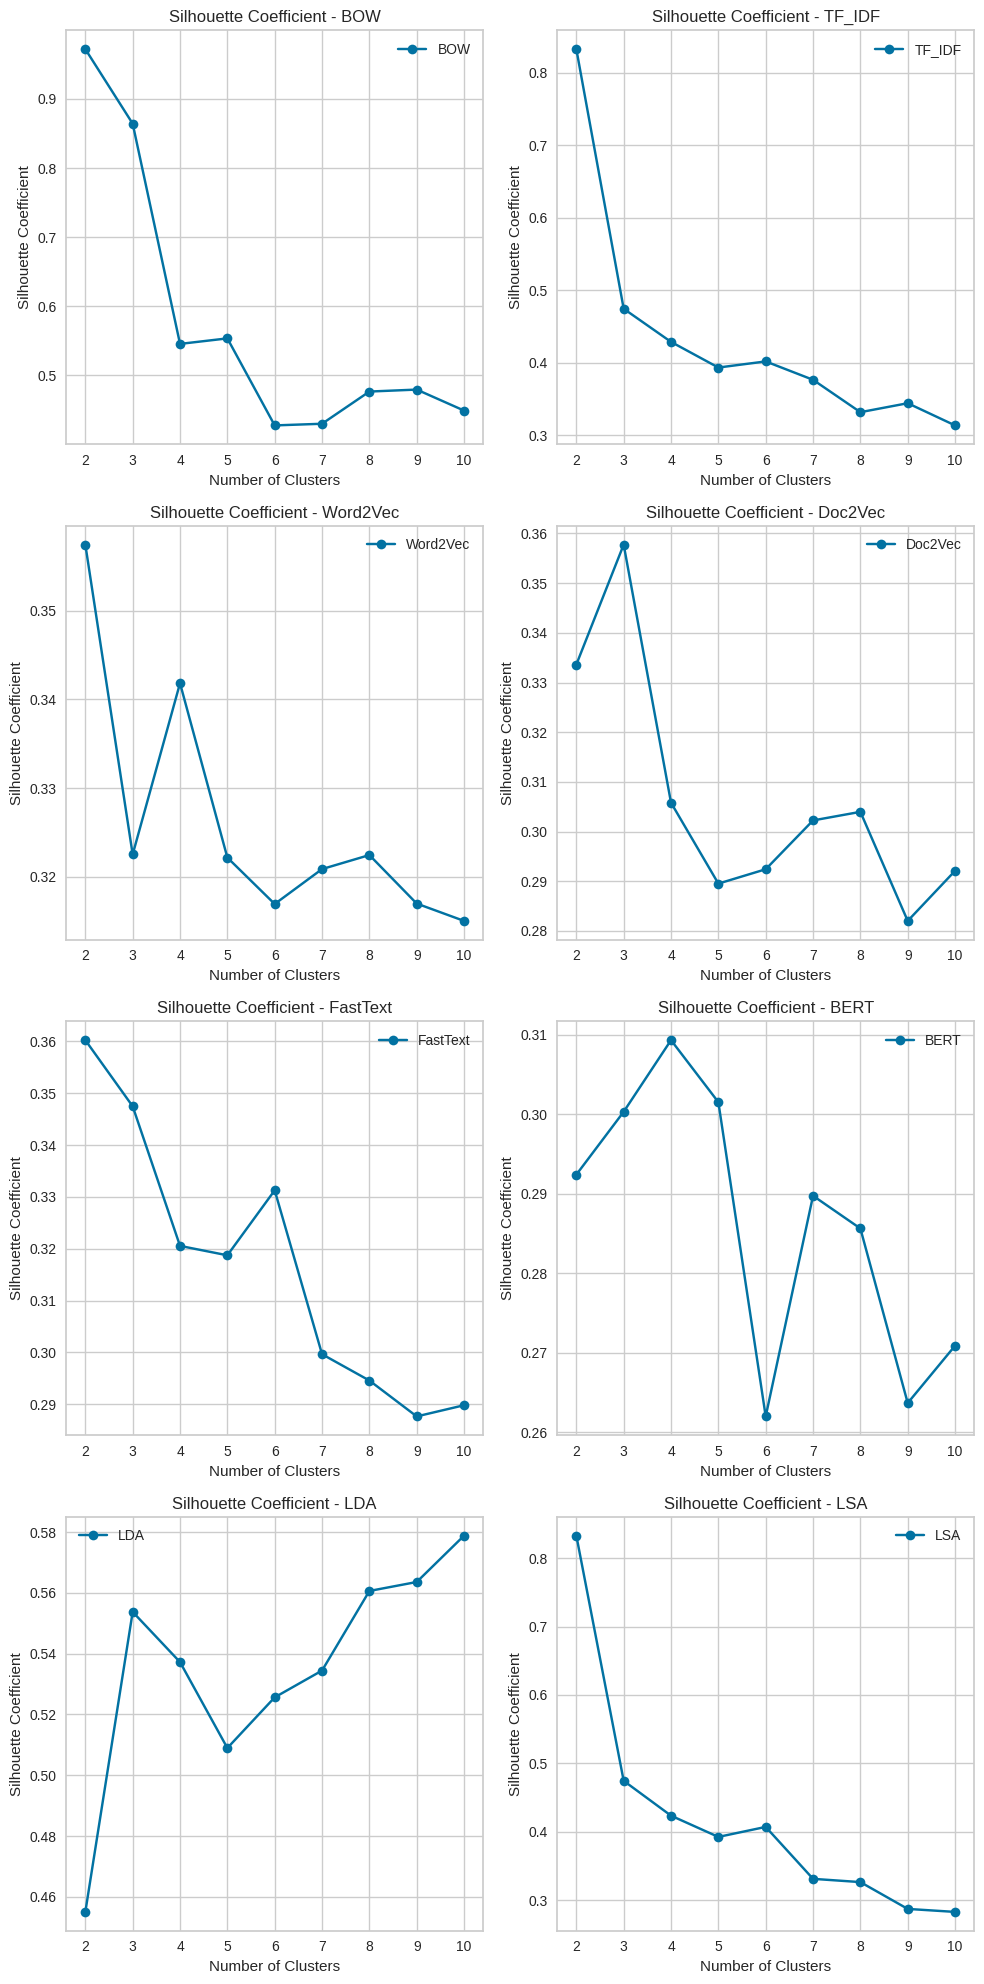

In [75]:
import matplotlib.pyplot as plt

# Assuming you have already executed the previous code and have the results in kmeans_sil_vec

# Calculate the number of text embeddings
num_embeddings = len(agg_sil_vec)

# Calculate the number of columns for subplots
num_cols = min(num_embeddings, 2)

# Calculate the number of rows for subplots
num_rows = (num_embeddings + num_cols - 1) // num_cols

# Create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Ensure axes is always a 2D array
if num_rows == 1:
    axes = axes.reshape(1, -1)
elif num_cols == 1:
    axes = axes.reshape(-1, 1)

# Iterate over the text embeddings and their respective silhouette coefficients
for i, (k, v) in enumerate(agg_sil_vec.items()):
    ax = axes[i // num_cols, i % num_cols]  # Get the current axis

    ax.plot(range(2, len(v) + 2), v, marker='o', linestyle='-', label=k)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Silhouette Coefficient')
    ax.set_title(f'Silhouette Coefficient - {k}')
    ax.legend()

# Hide unused subplots
if num_embeddings < num_rows * num_cols:
    for j in range(num_embeddings, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


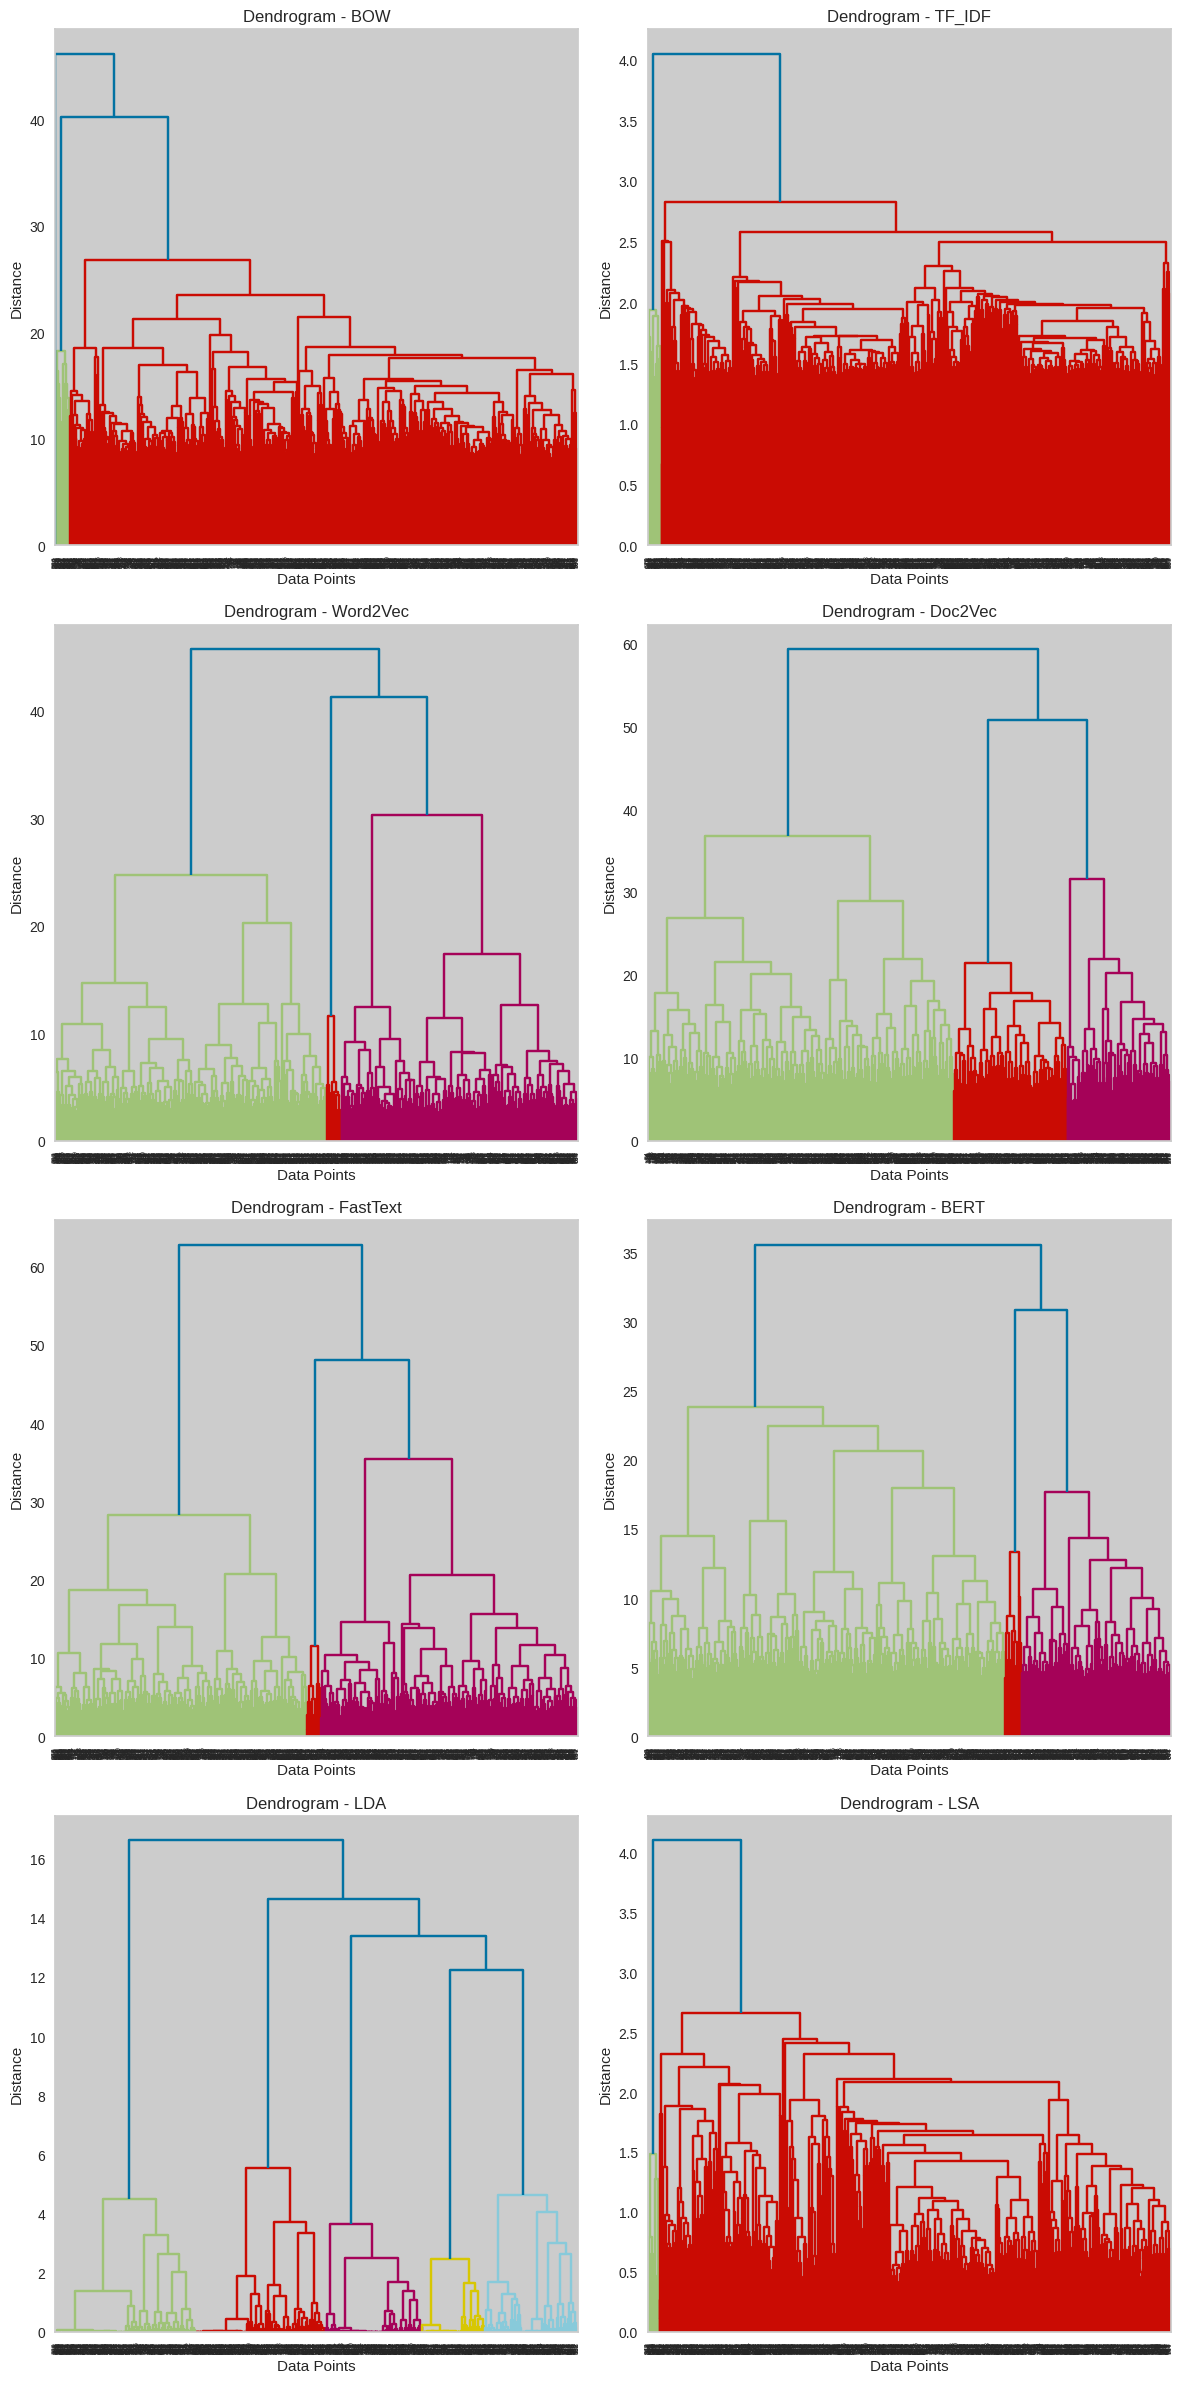

In [76]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Create subplots to display the dendrograms side by side
num_plots = len(text_embedding)
num_rows = num_plots // 2 if num_plots % 2 == 0 else num_plots // 2 + 1
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6*num_rows))

# Iterate over each text embedding
for i, (method, data) in enumerate(text_embedding.items()):
    row_idx = i // 2
    col_idx = i % 2

    # Compute the linkage matrix and plot the dendrogram
    linkage_matrix = linkage(data, method='ward', metric='euclidean')
    ax = axes[row_idx, col_idx]
    dendrogram(linkage_matrix, ax=ax)
    ax.set_title(f'Dendrogram - {method}')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Distance')

# Adjust the layout and spacing
plt.tight_layout()

# Display the plots
plt.show()

In [77]:
vecs = list(text_embedding.keys())
vec_kappa = dict()
results = []  # Store the results

for vec in vecs:
    # Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=5)
    agg_labels = agg_clustering.fit_predict(reduce_data(text_embedding[vec]))
    agg_score = silhouette_score(reduce_data(text_embedding[vec]), agg_labels, metric='euclidean')

    true_labels = encode_label()
    mapped_labels = remap_labels(true_labels, agg_labels)
    kappa_score = cohen_kappa_score(mapped_labels, agg_labels)

    # Append the results to the list
    results.append([vec, agg_score, kappa_score])

# Tabulate the results
headers = ['Text Embedding', 'Silhouette Score', "Cohen's Kappa Score"]
table = tabulate(results, headers, tablefmt='fancy_grid')

# Print the table
print(table)


╒══════════════════╤════════════════════╤═══════════════════════╕
│ Text Embedding   │   Silhouette Score │   Cohen's Kappa Score │
╞══════════════════╪════════════════════╪═══════════════════════╡
│ BOW              │           0.553611 │             0.0205474 │
├──────────────────┼────────────────────┼───────────────────────┤
│ TF_IDF           │           0.393279 │             0.602666  │
├──────────────────┼────────────────────┼───────────────────────┤
│ Word2Vec         │           0.322163 │            -0.222362  │
├──────────────────┼────────────────────┼───────────────────────┤
│ Doc2Vec          │           0.289527 │            -0.205569  │
├──────────────────┼────────────────────┼───────────────────────┤
│ FastText         │           0.318745 │            -0.221919  │
├──────────────────┼────────────────────┼───────────────────────┤
│ BERT             │           0.301545 │            -0.0899859 │
├──────────────────┼────────────────────┼───────────────────────┤
│ LDA     

In [78]:
calculate_kappa_score("Agglomerative")

In [94]:
TF_IDF_agg=text_embedding['TF_IDF']

In [95]:

pca_df_agg = apply_PCA(TF_IDF_agg)
pca_df_final_agg = pd.concat([pca_df_agg, pd.Series(true_labels,name='target')],axis=1)
pca_df_final_agg

principal component 1  principal component 2  target
0                -0.051407               0.062953       0
1                 0.066303              -0.002608       0
2                -0.003988              -0.042894       0
3                 0.014054              -0.013288       0
4                 0.040334              -0.057086       0
..                     ...                    ...     ...
995              -0.084640               0.193808       2
996               0.004246               0.002939       2
997              -0.000511               0.013052       2
998               0.067145               0.103736       2
999              -0.046882               0.108172       2

[1000 rows x 3 columns]

In [96]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=5)
agglomerative_labels = agglomerative.fit_predict(pca_df_agg)
agglomerative_df_final = pd.concat([pca_df_agg,pd.Series(agglomerative_labels, name='target')], axis=1)
agglomerative_df_final


principal component 1  principal component 2  target
0                -0.051407               0.062953       2
1                 0.066303              -0.002608       0
2                -0.003988              -0.042894       0
3                 0.014054              -0.013288       0
4                 0.040334              -0.057086       0
..                     ...                    ...     ...
995              -0.084640               0.193808       1
996               0.004246               0.002939       2
997              -0.000511               0.013052       2
998               0.067145               0.103736       2
999              -0.046882               0.108172       1

[1000 rows x 3 columns]

In [97]:
df_labels_agg = pd.DataFrame({'Labels': pca_df_final_agg['target'], 'Predicted Labels': list(agglomerative_df_final['target'])})
predicted_labels = df_labels_agg['Predicted Labels'].values

# Remap the predicted labels based on the true labels
remapped_labels = remap_labels(df_labels_agg['Labels'].values, predicted_labels)

agglomerative_df_final['target'] = remapped_labels


In [98]:
from plotly.subplots import make_subplots
fig1 = px.scatter(data_frame =pca_df_final_agg, x='principal component 1', y='principal component 2', color='target')
fig1.update_layout({'title':{'text': 'The Clusters with Actual Labels','x':0.5}},height=600,width=600)
fig1.show()
fig2 = px.scatter(data_frame =agglomerative_df_final, x='principal component 1', y='principal component 2', color='target')
fig2.update_layout(annotations=[
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[0][0],
            y=centroids[0][1],
            text="X"),
        dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[1][0],
            y=centroids[1][1],
            text="X",
),
        dict(font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[2][0],
            y=centroids[2][1],
            text="X",
        ),
dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[3][0],
            y=centroids[3][1],
            text="X",
        ),dict(
            font=dict(color='black',size=30),
            showarrow=False,
            x=centroids[4][0],
            y=centroids[4][1],
            text="X",
        )],height=600,width=600)
fig2.update_layout({'title':{'text': 'The Clusters with Agglomerative','x':0.5},},height=600,width=600)
fig2.show()

##Error Analysis


In [84]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

k = 5
embedding = text_embedding['FastText']
gmm_model = GaussianMixture(n_components=k, random_state=42)
predicted_labels = gmm_model.fit_predict(embedding)
true_labels = encode_label()
mapped_labels = remap_labels(true_labels, predicted_labels)

# Create a DataFrame for mapping
mapping_df = pd.DataFrame({'y_actual': true_labels, 'y_pred': mapped_labels})


wrong_examples_pred_actual = mapping_df[mapping_df['y_actual'] != mapping_df['y_pred']]
wrong_idx = wrong_examples_pred_actual.index.tolist()
wrong_examples_pred_actual['samples'] = list(embedding[wrong_idx, :])

books = pd.DataFrame()
books['labels'] = true_labels
books['samples'] = list(embedding)
book_means = books.groupby('labels').mean()

wrong_smi = []
correct_smi = []
for i in range(len(wrong_examples_pred_actual)):
    true_book = book_means.loc[wrong_examples_pred_actual.iloc[i]['y_actual']][:][0].reshape(1, -1)
    wrong_book = book_means.loc[wrong_examples_pred_actual.iloc[i]['y_pred']][:][0].reshape(1, -1)
    sample = wrong_examples_pred_actual.iloc[i]['samples'].reshape(1, -1)

    wrong_similarity = cosine_similarity(sample, wrong_book)
    right_similarity = cosine_similarity(sample, true_book)
    wrong_smi.append(wrong_similarity[0][0])
    correct_smi.append(right_similarity[0][0])

wrong_examples_pred_actual['Wrong Similarity'] = wrong_smi
wrong_examples_pred_actual['Correct Similarity'] = correct_smi

wrong_examples_pred_actual


y_actual  y_pred                                            samples  \
0           0       2  [-0.5997813, -0.49737722, -0.7864702, -1.34260...   
1           0       4  [-0.23043737, 0.080006875, 0.17952904, -0.3998...   
2           0       2  [0.3025332, -0.7046235, -0.6077157, -0.4564280...   
3           0       2  [-0.23377772, 0.15337458, -0.07142173, -0.2055...   
4           0       4  [-0.45487922, -0.4976486, -0.14202528, 0.33045...   
..        ...     ...                                                ...   
990         2       1  [-0.4817975, 0.10976648, -0.30059865, -1.21044...   
991         2       1  [-0.2039109, 0.18280476, -0.50672233, -1.03712...   
992         2       1  [0.23413487, -0.2866287, -0.30262095, -0.39316...   
995         2       1  [-0.03858131, -0.4057037, -0.73738945, -0.8891...   
999         2       1  [0.5329972, -0.64260006, -0.43034315, -0.52488...   

     Wrong Similarity  Correct Similarity  
0            0.711040            0.717474  
1            0.523328            0.596099  
2            0.638152            0.602624  
3            0.683262            0.559791  
4            0.583321            0.457777  
..                ...                 ...  
990          0.753046            0.843527  
991          0.758568            0.809343  
992          0.679557            0.807262  
995          0.742340            0.853580  
999          0.719365            0.773433  

[439 rows x 5 columns]

In [85]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

k = 5
embedding = text_embedding['FastText']
gmm_model = GaussianMixture(n_components=k, random_state=42)
predicted_labels = gmm_model.fit_predict(embedding)
true_labels = encode_label()
mapped_labels = remap_labels(true_labels, predicted_labels)

# Create a DataFrame for mapping
mapping_df = pd.DataFrame({'y_actual': true_labels, 'y_pred': mapped_labels})

correct_examples_pred_actual = mapping_df[mapping_df['y_actual'] == mapping_df['y_pred']]
correct_idx = correct_examples_pred_actual.index.tolist()
correct_examples_pred_actual['samples'] = list(embedding[correct_idx, :])

books = pd.DataFrame()
books['labels'] = true_labels
books['samples'] = list(embedding)
book_means = books.groupby('labels').mean()

correct_smi = []
for i in range(len(correct_examples_pred_actual)):
    true_book = book_means.loc[int(correct_examples_pred_actual.iloc[i]['y_actual'])][:][0].reshape(1, -1)
    sample = correct_examples_pred_actual.iloc[i]['samples'].reshape(1, -1)

    right_similarity = cosine_similarity(sample, true_book)
    correct_smi.append(right_similarity[0][0])

correct_examples_pred_actual['Correct Similarity'] = correct_smi

correct_examples_pred_actual


y_actual  y_pred                                            samples  \
200         4       4  [0.45510498, 0.09081283, 0.076118276, 0.233354...   
201         4       4  [0.7170171, 0.653468, -0.30192718, 0.8966977, ...   
203         4       4  [0.19458841, -0.13399768, 0.006027055, 0.16746...   
205         4       4  [0.0972198, -0.18668348, -1.6594372, -0.397477...   
206         4       4  [0.07112337, 0.4459329, -0.1427541, 0.664972, ...   
..        ...     ...                                                ...   
993         2       2  [-0.43133408, 0.3404125, -0.09656591, -0.50076...   
994         2       2  [-0.49036357, 0.03898357, 0.34960845, -0.47800...   
996         2       2  [0.47790778, 0.29246962, -0.37785843, 0.541055...   
997         2       2  [0.5424431, 0.14282133, -0.49380904, -0.684965...   
998         2       2  [0.34250525, -0.7711898, -0.62930316, -1.07268...   

     Correct Similarity  
200            0.672490  
201            0.657749  
203            0.481098  
205            0.620048  
206            0.807932  
..                  ...  
993            0.749032  
994            0.704152  
996            0.625332  
997            0.659297  
998            0.722715  

[561 rows x 4 columns]

In [86]:
# the wrongly classified examples
wrong_sample_analsis = pd.concat([wrong_examples_pred_actual[['y_actual','y_pred']], df.loc[wrong_idx]['Paragraphs']], axis=1)
wrong_sample_analsis

y_actual  y_pred                                         Paragraphs
0           0       2  suddenly hear sound step within room saw shado...
1           0       4  go strange wonderful chain work lead would mak...
2           0       2  wonderful sympathy freemasonry among horsey on...
3           0       2  look give flick horse dash away endless succes...
4           0       4  reasoner able utilise facts come readily posse...
..        ...     ...                                                ...
990         2       1  car watching saw wad muscle back shoulder tigh...
991         2       1  always last ones leave go new york see sister ...
992         2       1  come officer look daisy way every young girl w...
995         2       1  continue almost tom turn live near sloane ente...
999         2       1  friend jew raise large head regard two fine gr...

[439 rows x 3 columns]

In [87]:
from collections import Counter

for i in range(len(wrong_sample_analsis)):
  y_actual = wrong_sample_analsis['y_actual'].iloc[i]
  y_pred = wrong_sample_analsis['y_pred'].iloc[i]
  sample = wrong_sample_analsis['Paragraphs'].iloc[i]
  counter = Counter(sample.split())
  most_occur = counter.most_common(10)

  true_label = Counter(df.groupby(['Author'], as_index=False).agg({'Paragraphs': ' '.join}).iloc[y_actual,1].split())
  wrong_label = Counter(df.groupby(['Author'], as_index=False).agg({'Paragraphs': ' '.join}).iloc[y_pred,1].split())

  word_freq_in_both_books = {}
  for word, occur in most_occur:
    word_freq_in_both_books[word] = {'true_label':true_label[word], 'wrong_label': wrong_label[word],'diff':(true_label[word] - wrong_label[word]) ,'occur': occur}
  print(pd.DataFrame(word_freq_in_both_books).T)
  print('*'*50)
  print('*'*50)

Streaming output truncated to the last 5000 lines.
devise             2            0     2      1
seven              2            1     1      1
separate           1            2    -1      1
would             71          108   -37      1
cover              5            0     5      1
facts              9            0     9      1
**************************************************
**************************************************
           true_label  wrong_label  diff  occur
would              71           26    45      3
stone              11            0    11      2
geese               3            0     3      2
seize               5            1     4      1
waistcoat           1            0     1      1
lean                4           16   -12      1
wall                3            0     3      1
time               21           42   -21      1
look               43           81   -38      1
waddle              1            0     1      1
*************************************